# Kobe Bryant Shot Selection

Data from kaggle: https://www.kaggle.com/c/kobe-bryant-shot-selection/data

__Goal__: Predict whether a shot taken by Kobe Bryant was a make or a miss

__Data Overview__: Data for each shot taken by Kobe Bryant in his career. Fields include location on court, shot type, location of game, season, and some premade categorical variables around these categories. 

In [2]:
# imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("../datasets/kobe/data.csv")
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
df.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


In [5]:
df.shape

(30697, 25)

To be more realistic with our train/validation split, we should not ignore time series effects (i.e. it is plausible that Kobe gets better or worse as years have gone by). In order to reduce data leakage *(using the future to predict past events)* we will order the data by game date and then take the final 30% as our validation. This better simulates how a model like this would be used in a real environment (predicting a shot, when it is taken)

In [6]:
def train_validation_split(df, percentage_training):
    '''
    splits a data frame into training and validation sets
    '''
    number_rows = round(percentage_training * df.shape[0])
    train = df[:number_rows]
    valid = df[number_rows:]
    return(train, valid)

In [7]:
df.sort_values(by = 'game_date', inplace = True)

In [8]:
train, valid = train_validation_split(df, percentage_training = .70)

In [9]:
#df.shape
#train.shape
#valid.shape

We also need a baseline. An intuitive baseline to know if our classifier is any good is to see it is an improvement over guessing "make" for all of them. We should calculate Kobe's FG % for our overall data (through training + validation)

In [10]:
df.groupby(by = 'shot_made_flag').count()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
shot_made_flag,,,,,,,,,,,,,,,,,,,,,
0.0,14232,14232,14232,14232,14232,14232,14232,14232,14232,14232,...,14232,14232,14232,14232,14232,14232,14232,14232,14232,14232
1.0,11465,11465,11465,11465,11465,11465,11465,11465,11465,11465,...,11465,11465,11465,11465,11465,11465,11465,11465,11465,11465


In [11]:
baseline = 11465/(11465 + 14232)
baseline

0.44616103047048294

Let's do a visualization of locations vs where shots are made

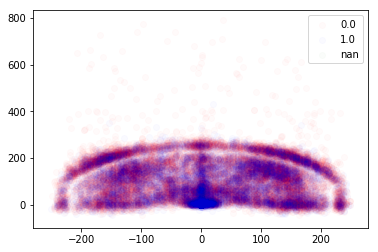

In [12]:
# miss is red, make is blue

made = list(df['shot_made_flag'].unique())
col_list = ['red', 'blue', 'green']
for i in range(0 , len(made)):
    data = df.loc[df['shot_made_flag'] == made[i]]
    x = data.loc_x
    y = data.loc_y
    plt.scatter(x, y, color=col_list[i], label=made[i], alpha = 0.02)
plt.legend()
plt.show()

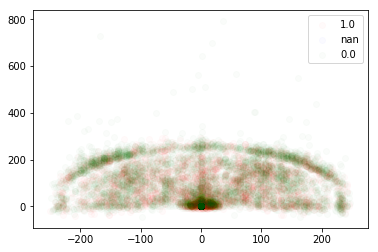

In [13]:
# just for validation

made = list(valid['shot_made_flag'].unique())
col_list = ['red', 'blue', 'green']
for i in range(0 , len(made)):
    data = valid.loc[df['shot_made_flag'] == made[i]]
    x = data.loc_x
    y = data.loc_y
    plt.scatter(x, y, color=col_list[i], label=made[i], alpha = 0.02)
plt.legend()
plt.show()

Turns out, after reading the documentation a little closer.. the NaN values are the kaggle test set. Let's split this off, call it test, and then redo our training/validation split

In [14]:

test = df[np.isnan(df.shot_made_flag)]
#test.head()
test.shape

(5000, 25)

In [15]:
rest = df[~np.isnan(df.shot_made_flag)]
train, valid = train_validation_split(rest, percentage_training = .70)

In [16]:
train.shape

(17988, 25)

In [17]:
def plot_shots(df, y_col):
    made = [0,1]
    col_list = ['red', 'blue']
    for i in range(0 , len(made)):
        data = df.loc[df[y_col] == made[i]]
        x = data.loc_x
        y = data.loc_y
        plt.scatter(x, y, color=col_list[i], label=made[i], alpha = 0.02)
    plt.legend()
    plt.show()

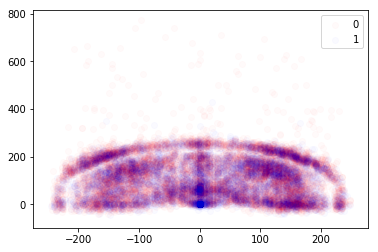

In [18]:
plot_shots(train, 'shot_made_flag')

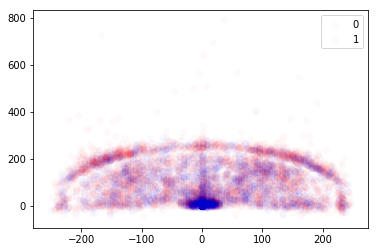

In [19]:
plot_shots(valid, 'shot_made_flag')

Training set looks pretty much like our validation set. We're probably OK to start some machine learning.


We will filter down the columns to make this problem a little more interpretable first before putting into any ML

In [20]:
train.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')

In [21]:
columns_kept = ['lat', 'lon', 'loc_x', 'loc_y', 'game_date', 'minutes_remaining', 'period']

y_train = train.shot_made_flag
y_valid = train.shot_made_flag
x_train = train[columns_kept]
x_valid = valid[columns_kept]
# y_test = test.shot_made_flag
# x_test = test[columns_kept]

In [22]:
x_train.head()

,lat,lon,loc_x,loc_y,game_date,minutes_remaining,period
22901,33.9283,-118.4098,-140,116,1996-11-03,0,1
22902,33.9473,-118.4008,-131,97,1996-11-05,10,2
22903,33.8633,-118.4118,-142,181,1996-11-06,8,2
22904,34.0443,-118.2698,0,0,1996-11-06,6,2
22905,33.9063,-118.2798,-10,138,1996-11-06,5,2


In [23]:
x_train.shape

(17988, 7)

In [24]:
y_train.shape

(17988,)

We need to process the game date

In [25]:
def add_month_year(df, date_col):  
    dates = pd.to_datetime(df[date_col])
    df['year'] = dates.apply(lambda x: x.year)
    df['month'] = dates.apply(lambda x: x.month)
    df.drop([date_col], axis=1, inplace = True)
    return df


In [26]:
# test = add_month_year(test, 'game_date')
x_train = add_month_year(x_train, 'game_date')
x_valid = add_month_year(x_valid, 'game_date')

C:\Users\johnb\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\johnb\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\johnb\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

In [27]:

x_train.head()

,lat,lon,loc_x,loc_y,minutes_remaining,period,year,month
22901,33.9283,-118.4098,-140,116,0,1,1996,11
22902,33.9473,-118.4008,-131,97,10,2,1996,11
22903,33.8633,-118.4118,-142,181,8,2,1996,11
22904,34.0443,-118.2698,0,0,6,2,1996,11
22905,33.9063,-118.2798,-10,138,5,2,1996,11


In [28]:
x_train.shape

(17988, 8)

In [29]:
y_train.shape

(17988,)

Use Amit's helpful scripts

In [30]:
from sklearn.preprocessing import StandardScaler

def scale_features(X):

    scaler = StandardScaler()
    scaler.fit(X)  # Don't cheat - fit only on training data
    return scaler.transform(X)

def train_classifer(classifier, df, feature_cols, label_col='label'):
    X,y = training_data_from_dataframe(df, feature_cols)
    trained_classifier = classifier.fit(X,y) 
    return trained_classifier

def classifier_predict(trained_classifer, df, feature_cols, label_col='label'):
    X,y = training_data_from_dataframe(df, feature_cols)
    y_predict = trained_classifier.predict(X)
    df['predict'] = y_predict
    accuracy = 1. * sum(y == y_predict) / len(y)
    return accuracy



In [31]:
predictors = list(x_train.columns)

### Machine learning algorithms, results

##### Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
trained_classifier = classifier.fit(x_train[predictors], y_train)
y_predict = trained_classifier.predict(x_valid[predictors])
x_valid['NBpredict'] = y_predict

C:\Users\johnb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


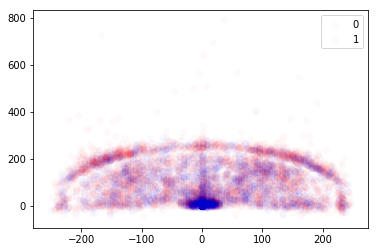

In [33]:
# actual
plot_shots(valid, 'shot_made_flag')

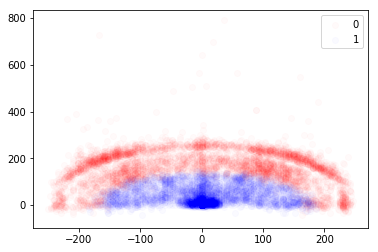

In [34]:
# predicted
plot_shots(x_valid, 'NBpredict')

In [35]:
def accuracy_measure(predictions, actuals):
    accuracy = 1 - sum(abs(predictions - actuals))/len(actuals)
    # print("Prediction Accuracy: " + str(accuracy))
    return accuracy

In [36]:
# absolute baseline of just guessing 1
accuracy_measure(1, valid['shot_made_flag'])

0.4293682708522506

In [37]:
# train accuracy
y_train_pred = trained_classifier.predict(x_train[predictors])
accuracy_measure(y_train_pred, y_train)

0.5706026239715366

In [38]:
# validation accuracy
accuracy_measure(x_valid['NBpredict'], valid['shot_made_flag'])

0.5801011804384486

So Naive Bayes is better than just guessing that a shot was made all the time. That's a good start!

Training and validation accuracies are pretty close, so that is good

##### Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
trained_classifier = classifier.fit(x_train[predictors], y_train)
y_predict = trained_classifier.predict(x_valid[predictors])
x_valid['RFpredict'] = y_predict

C:\Users\johnb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


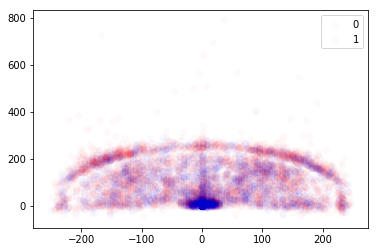

In [40]:
# actual
plot_shots(valid, 'shot_made_flag')

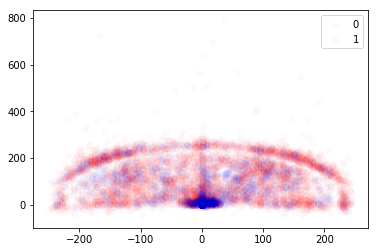

In [41]:
# predicted
plot_shots(x_valid, 'RFpredict')

In [42]:
# training accuracy
y_train_pred = trained_classifier.predict(x_train[predictors])
accuracy_measure(y_train_pred, y_train)

0.94585279074938844

In [43]:
# testing accuracy
accuracy_measure(x_valid['RFpredict'], valid['shot_made_flag'])

0.55299001167466599

So we have a worse result than our baseline, but not as good as Naive Bayes. This is probably because we have overfit to some degree as this is a much more complex model. We have also overfit this into oblivion- our training accuracy is nearly perfect, but the validation accuracy is much lower. Let's try some hyperparameter changes and see if we can't make this different.

In [44]:
classifier = RandomForestClassifier(n_estimators = 300, min_samples_leaf = 25, max_features = 5, n_jobs = -1)
trained_classifier = classifier.fit(x_train[predictors], y_train)
y_predict = trained_classifier.predict(x_valid[predictors])
x_valid['RFpredict2'] = y_predict

C:\Users\johnb\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


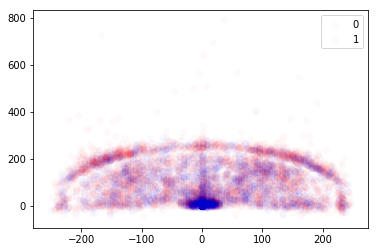

In [45]:
# actual
plot_shots(valid, 'shot_made_flag')

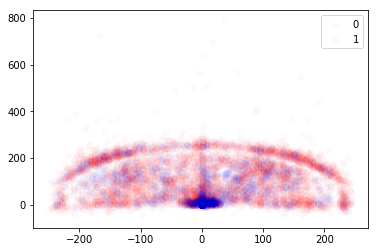

In [46]:
# predicted
plot_shots(x_valid, 'RFpredict')

In [47]:
# training accuracy
y_train_pred = trained_classifier.predict(x_train[predictors])
accuracy_measure(y_train_pred, y_train)

0.66205247943073164

In [48]:
# testing accuracy
accuracy_measure(x_valid['RFpredict2'], valid['shot_made_flag'])

0.59981839408483584

We still experience some overfitting here with the notable loss in accuracy between training and test- however, this still gives us our best result yet! The hyperparameters chose made the decisions trees shorter and more dissimilar, but created more of them. Having more decision trees that are different makes the prediction more robust.



In [49]:
from sklearn.metrics import log_loss

log_loss(valid['shot_made_flag'], x_valid['RFpredict2'], eps=1e-15)

13.821886830370616

Log loss was the metric on kaggle for this competition... The best results on the public leaderboard were in the ballpark of 0.6. We have a long way to go!